In [149]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

gpd.options.use_pygeos = True 

/var/folders/zx/x6hb1_p95p33hh3235qrnlqm0000gn/T/ipykernel_54276/3224799141.py:5: UserWarning: pygeos support was removed in 1.0. geopandas.use_pygeos is a no-op and will be removed in geopandas 1.1.
  gpd.options.use_pygeos = True


In [150]:
# 1. Load CONUS grid geometry
grids = gpd.read_file("/Users/koacow/repos/glob-s-RA/patents/grid_panel/data/grid.geojson")
grids

,grid_id,geometry
0,195,"POLYGON ((-81 25.25, -81 25.12432, -81.0096 25..."
1,196,"POLYGON ((-81 25.25, -80.75 25.25, -80.75 25.1..."
2,197,"MULTIPOLYGON (((-80.55905 25, -80.54476 25.012..."
3,198,"POLYGON ((-80.5 25.25, -80.3103 25.25, -80.327..."
4,456,"POLYGON ((-81 25.5, -81 25.25, -81.16944 25.25..."
...,...,...
15433,25195,"POLYGON ((-95 49.25, -95 49, -95.15371 49, -95..."
15434,25196,"POLYGON ((-94.75 49, -95 49, -95 49.25, -94.80..."
15435,25197,"POLYGON ((-94.75 49, -94.75 49.09906, -94.7189..."
15436,25456,"POLYGON ((-95 49.25, -95.15342 49.25, -95.1533..."


In [151]:
# 1.2 Load counties geometry
counties = gpd.read_file(
    "/Users/koacow/repos/glob-s-RA/patents/grid_control_outcome/data/cb_2018_us_county_5m/cb_2018_us_county_5m.shp",
).to_crs(epsg=4326)[["GEOID", "geometry"]].rename(
    columns={"GEOID": "FIPS5"}
)
counties

,FIPS5,geometry
0,39071,"POLYGON ((-83.86976 39.05553, -83.86568 39.247..."
1,06003,"POLYGON ((-120.07248 38.50987, -120.07239 38.7..."
2,12033,"POLYGON ((-87.62999 30.87766, -87.62946 30.880..."
3,17101,"POLYGON ((-87.91028 38.57493, -87.90811 38.850..."
4,28153,"POLYGON ((-88.94317 31.78421, -88.94336 31.824..."
...,...,...
3228,42055,"POLYGON ((-78.09897 39.72247, -78.0693 39.7483..."
3229,12001,"POLYGON ((-82.65855 29.83014, -82.65149 29.825..."
3230,48247,"POLYGON ((-98.95467 27.2694, -98.79809 27.2680..."
3231,29099,"POLYGON ((-90.7628 38.29555, -90.7556 38.33005..."


In [152]:
# 2.1 Load patent innovation data
innovation_measures = pd.read_csv(
    "/Users/koacow/BOSTON UNIVERSITY Dropbox/Ngoc Duy Khoa Cao/GLOB~S/Research Projects/Shocks and Innovation/Patent Data/Innovation Measures/patents_innovation_measures.csv",
    dtype={"patent_id": str, "patent_date": str},
    usecols=["patent_id", "atypicality_score", "fwd_citation_impact_score", "entropy_score", "patent_date"]
)
innovation_measures["year"] = pd.to_datetime(innovation_measures["patent_date"]).dt.year
innovation_measures = innovation_measures.drop_duplicates(subset=["patent_id"], keep="first")
innovation_measures = innovation_measures.drop(columns=["patent_date"])
innovation_measures

,patent_id,atypicality_score,fwd_citation_impact_score,entropy_score,year
0,10000000,NaN,18.195203,1.039721,2018
1,10000001,8.984207,NaN,-0.000000,2018
2,10000002,8.375340,NaN,1.627269,2018
3,10000003,6.990229,1.386294,0.881594,2018
4,10000004,6.239670,NaN,0.997282,2018
...,...,...,...,...,...
7507814,RE50254,NaN,NaN,NaN,2024
7507815,RE50255,NaN,NaN,1.329977,2024
7507816,RE50256,NaN,NaN,NaN,2024
7507817,RE50257,NaN,NaN,NaN,2024


In [153]:
# 2.2 Load patent coordinates
patent_data = pd.read_csv(
    "/Users/koacow/BOSTON UNIVERSITY Dropbox/Ngoc Duy Khoa Cao/GLOB~S/Research Projects/Shocks and Innovation/Patent Data/US Patents Data.csv",
    dtype={"patent_id": str, "patent_date": str},
    usecols=["patent_id", "latitude", "longitude", "patent_date"]
)
patent_data["year"] = pd.to_datetime(patent_data["patent_date"]).dt.year
patent_data = patent_data.drop_duplicates(subset=["patent_id"], keep="first")
patent_data = patent_data.drop(columns=["patent_date"])
patent_data

,patent_id,latitude,longitude,year
0,10000000,33.891599,-118.395124,2018
1,10000007,43.057848,-88.126198,2018
6,10000008,40.973154,-73.961526,2018
7,10000009,37.668821,-122.080796,2018
8,10000010,43.220897,-77.283042,2018
...,...,...,...,...
9325233,RE49664,37.379663,-122.137464,2023
9325235,RE49666,35.925206,-86.868942,2023
9325236,RE49667,29.723557,-98.935864,2023
9325237,RE49673,47.603832,-122.330062,2023


In [154]:
# 2.3 Merge innovation measures with patent coordinates
patent_data = patent_data.merge(
    innovation_measures,
    on="patent_id", 
    how="right",
    validate="one_to_one",
    suffixes=(None, "_y")
)
patent_data["year"] = patent_data["year"].combine_first(patent_data["year_y"])
patent_data = patent_data.drop(columns=["year_y"])
patent_data.to_csv("/Users/koacow/BOSTON UNIVERSITY Dropbox/Ngoc Duy Khoa Cao/GLOB~S/Research Projects/Shocks and Innovation/Patent Data/Innovation Measures/patent_innovation_measures_geolocated.csv", index=False)
patent_data

,patent_id,latitude,longitude,year,atypicality_score,fwd_citation_impact_score,entropy_score
0,10000000,33.891599,-118.395124,2018.0,NaN,18.195203,1.039721
1,10000001,NaN,NaN,2018.0,8.984207,NaN,-0.000000
2,10000002,NaN,NaN,2018.0,8.375340,NaN,1.627269
3,10000003,NaN,NaN,2018.0,6.990229,1.386294,0.881594
4,10000004,NaN,NaN,2018.0,6.239670,NaN,0.997282
...,...,...,...,...,...,...,...
7507814,RE50254,NaN,NaN,2024.0,NaN,NaN,NaN
7507815,RE50255,NaN,NaN,2024.0,NaN,NaN,1.329977
7507816,RE50256,NaN,NaN,2024.0,NaN,NaN,NaN
7507817,RE50257,NaN,NaN,2024.0,NaN,NaN,NaN


In [155]:
# 2.4 Convert patent coordinates to GeoDataFrame
geo_patent_data = gpd.GeoDataFrame(
    patent_data,
    geometry=gpd.points_from_xy(patent_data.longitude, patent_data.latitude),
    crs="EPSG:4326"
)
geo_patent_data

,patent_id,latitude,longitude,year,atypicality_score,fwd_citation_impact_score,entropy_score,geometry
0,10000000,33.891599,-118.395124,2018.0,NaN,18.195203,1.039721,POINT (-118.39512 33.8916)
1,10000001,NaN,NaN,2018.0,8.984207,NaN,-0.000000,POINT (NaN NaN)
2,10000002,NaN,NaN,2018.0,8.375340,NaN,1.627269,POINT (NaN NaN)
3,10000003,NaN,NaN,2018.0,6.990229,1.386294,0.881594,POINT (NaN NaN)
4,10000004,NaN,NaN,2018.0,6.239670,NaN,0.997282,POINT (NaN NaN)
...,...,...,...,...,...,...,...,...
7507814,RE50254,NaN,NaN,2024.0,NaN,NaN,NaN,POINT (NaN NaN)
7507815,RE50255,NaN,NaN,2024.0,NaN,NaN,1.329977,POINT (NaN NaN)
7507816,RE50256,NaN,NaN,2024.0,NaN,NaN,NaN,POINT (NaN NaN)
7507817,RE50257,NaN,NaN,2024.0,NaN,NaN,NaN,POINT (NaN NaN)


In [156]:
# 3. Spatial join to assign innovation measures to grid cells
patent_grid = gpd.sjoin(
    geo_patent_data,
    grids,
    how="inner",
    predicate="within"
).drop(columns=["index_right"])
patent_grid

,patent_id,latitude,longitude,year,atypicality_score,fwd_citation_impact_score,entropy_score,geometry,grid_id
0,10000000,33.891599,-118.395124,2018.0,NaN,18.195203,1.039721,POINT (-118.39512 33.8916),9181
7,10000007,43.057848,-88.126198,2018.0,6.239670,16.755626,2.813789,POINT (-88.1262 43.05785),18959
8,10000008,40.973154,-73.961526,2018.0,9.454074,NaN,1.955446,POINT (-73.96153 40.97315),16667
9,10000009,37.668821,-122.080796,2018.0,5.978974,17.793597,1.941785,POINT (-122.0808 37.66882),13081
10,10000010,43.220897,-77.283042,2018.0,9.475010,NaN,1.910784,POINT (-77.28304 43.2209),19002
...,...,...,...,...,...,...,...,...,...
7507226,RE49664,37.379663,-122.137464,2023.0,NaN,NaN,1.839735,POINT (-122.13746 37.37966),12820
7507228,RE49666,35.925206,-86.868942,2023.0,NaN,NaN,1.535105,POINT (-86.86894 35.92521),11395
7507229,RE49667,29.723557,-98.935864,2023.0,NaN,NaN,0.920352,POINT (-98.93586 29.72356),4822
7507235,RE49673,47.603832,-122.330062,2023.0,NaN,NaN,0.714040,POINT (-122.33006 47.60383),23520


In [157]:
agg_patent_grid = (
    patent_grid.groupby(["grid_id", "year"])
    .agg(
        num_patents=("patent_id", "nunique"),
        mean_atypicality_score=("atypicality_score", "mean"),
        mean_fwd_citation_impact_score=("fwd_citation_impact_score", "mean"),
        mean_entropy_score=("entropy_score", "mean")
    ).reset_index()
)
agg_patent_grid.to_parquet(
    "/Users/koacow/repos/glob-s-RA/patents/grid_control_outcome/data/grid_innovation_measures.parquet",
    index=False
)
agg_patent_grid

,grid_id,year,num_patents,mean_atypicality_score,mean_fwd_citation_impact_score,mean_entropy_score
0,10010,1998.0,2,9.827888,103.920437,1.711617
1,10010,1999.0,2,9.647409,53.994670,2.036181
2,10010,2001.0,1,9.647409,38.599998,1.984261
3,10010,2002.0,1,NaN,41.540681,0.673012
4,10010,2003.0,1,NaN,0.000000,0.206192
...,...,...,...,...,...,...
103543,9997,2012.0,1,NaN,0.000000,1.860789
103544,9997,2014.0,2,10.470154,0.693147,1.422876
103545,9997,2015.0,1,NaN,3.121421,1.556612
103546,9997,2020.0,1,NaN,NaN,0.491695


In [158]:
# 4. Map county control variables to grid cells
county_controls = pd.read_parquet(
    "/Users/koacow/BOSTON UNIVERSITY Dropbox/Ngoc Duy Khoa Cao/GLOB~S/Data/U.S. County Data/county_controls/county_controls_1980_2022.parquet",
)
county_controls["median_household_income"] = county_controls["median_household_income"].astype(float)
county_controls

,FIPS5,year,median_household_income,total_pop,white_pct,black_pct,asian_pct,other_pct,bachelors_pct,rgdp,personal_income,unemployment_rate,RUCC_2013
0,01001,1980,53255.0,32259.0,0.769212,0.223969,0.002542,0.004278,0.065625,NaN,250067.0,NaN,2.0
1,01001,1981,53255.0,32455.3,0.771608,0.221573,0.002638,0.004180,0.067905,NaN,261935.0,NaN,2.0
2,01001,1982,53255.0,32651.6,0.774004,0.219178,0.002735,0.004083,0.070185,NaN,280188.0,NaN,2.0
3,01001,1983,53255.0,32847.9,0.776400,0.216783,0.002831,0.003985,0.072464,NaN,302017.0,NaN,2.0
4,01001,1984,53255.0,33044.2,0.778797,0.214388,0.002928,0.003888,0.074744,NaN,337459.0,NaN,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
139487,72153,2018,14954.0,36439.0,0.773594,0.035676,0.000137,0.190592,0.175252,NaN,NaN,13.10,2.0
139488,72153,2019,14743.0,35428.0,0.751016,0.037993,0.000169,0.210822,0.177938,NaN,NaN,13.20,2.0
139489,72153,2020,14813.0,34172.0,0.213976,0.047319,0.000732,0.737973,0.180147,NaN,NaN,11.85,2.0
139490,72153,2021,16444.0,34704.0,0.706921,0.036941,0.000000,0.256138,0.191649,NaN,NaN,10.50,2.0


In [159]:
# 4.1 Assign weights to counties based on the share of the grid cell area occupied by each county
county_intersection = gpd.overlay(grids, counties, how="intersection")
county_intersection["area"] = county_intersection.geometry.to_crs(epsg=3857).area
area_total = county_intersection.groupby("grid_id")["area"].transform("sum")
county_intersection["area_weight"] = county_intersection["area"] / area_total
county_intersection

/opt/miniconda3/lib/python3.12/site-packages/geopandas/tools/overlay.py:357: UserWarning: `keep_geom_type=True` in overlay resulted in 10022 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  result = _collection_extract(result, geom_type, keep_geom_type_warning)


,grid_id,FIPS5,geometry,area,area_weight
0,195,12087,"POLYGON ((-81 25.12432, -81.0096 25.1254, -81....",2.448646e+08,1.000000
1,196,12086,"POLYGON ((-80.75 25.25, -80.75 25.14874, -80.7...",1.149840e+08,0.361811
2,196,12087,"POLYGON ((-80.85823 25.25, -80.85799 25.243, -...",2.028175e+08,0.638189
3,197,12086,"POLYGON ((-80.5 25.25, -80.5 25.20987, -80.501...",2.103633e+08,0.931176
4,197,12087,"MULTIPOLYGON (((-80.54476 25.01215, -80.5 25.0...",1.554823e+07,0.068824
...,...,...,...,...,...
33175,25195,27077,"POLYGON ((-95 49, -95.15371 49, -95.15331 49.1...",7.265431e+08,1.000000
33176,25196,27077,"POLYGON ((-95 49, -95 49.25, -94.80971 49.25, ...",1.076382e+09,1.000000
33177,25197,27077,"POLYGON ((-94.75 49.09906, -94.74578 49.08561,...",2.908813e+07,1.000000
33178,25456,27077,"POLYGON ((-95.15342 49.25, -95.15333 49.30566,...",3.263103e+08,1.000000


In [160]:
# 4.2 Merge county controls with the intersection weights
county_intersection = county_intersection[["FIPS5", "grid_id", "area_weight"]]
county_controls = county_controls.merge(
    county_intersection,
    on="FIPS5",
)
county_controls

,FIPS5,year,median_household_income,total_pop,white_pct,black_pct,asian_pct,other_pct,bachelors_pct,rgdp,personal_income,unemployment_rate,RUCC_2013,grid_id,area_weight
0,01001,1980,53255.0,32259.0,0.769212,0.223969,0.002542,0.004278,0.065625,NaN,250067.0,NaN,2.0,7741,0.236887
1,01001,1980,53255.0,32259.0,0.769212,0.223969,0.002542,0.004278,0.065625,NaN,250067.0,NaN,2.0,7742,0.512427
2,01001,1980,53255.0,32259.0,0.769212,0.223969,0.002542,0.004278,0.065625,NaN,250067.0,NaN,2.0,7743,0.158169
3,01001,1980,53255.0,32259.0,0.769212,0.223969,0.002542,0.004278,0.065625,NaN,250067.0,NaN,2.0,8002,0.401077
4,01001,1980,53255.0,32259.0,0.769212,0.223969,0.002542,0.004278,0.065625,NaN,250067.0,NaN,2.0,8003,0.799529
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1426735,56045,2022,71800.0,6870.0,0.864483,0.000873,0.002329,0.132314,0.125619,289622.0,350378.0,3.0,7.0,19935,0.225504
1426736,56045,2022,71800.0,6870.0,0.864483,0.000873,0.002329,0.132314,0.125619,289622.0,350378.0,3.0,7.0,19936,0.710609
1426737,56045,2022,71800.0,6870.0,0.864483,0.000873,0.002329,0.132314,0.125619,289622.0,350378.0,3.0,7.0,19937,0.718345
1426738,56045,2022,71800.0,6870.0,0.864483,0.000873,0.002329,0.132314,0.125619,289622.0,350378.0,3.0,7.0,19938,0.723535


In [161]:
# 4.3 Weight county control variables by the area weight and sum them up for each grid cell
control_cols = [col for col in county_controls.columns if col not in ["FIPS5", "year", "grid_id", "area_weight"]]
for col in control_cols:
    county_controls[col] = county_controls[col] * county_controls["area_weight"]

grid_controls = (
    county_controls.groupby(["grid_id", "year"])[control_cols]
    .sum()
    .reset_index()
)
grid_controls.to_parquet(
    "/Users/koacow/repos/glob-s-RA/patents/grid_control_outcome/data/grid_controls.parquet",
    index=False
)
grid_controls

,grid_id,year,median_household_income,total_pop,white_pct,black_pct,asian_pct,other_pct,bachelors_pct,rgdp,personal_income,unemployment_rate,RUCC_2013
0,10000,1980,30184.0,52108.0,0.228410,0.005201,0.001247,0.765142,0.044504,0.0,279338.0,0.0,6.0
1,10000,1981,30184.0,53056.3,0.225793,0.004843,0.001275,0.768089,0.044145,0.0,290786.0,0.0,6.0
2,10000,1982,30184.0,54004.6,0.223176,0.004485,0.001303,0.771036,0.043786,0.0,310708.0,0.0,6.0
3,10000,1983,30184.0,54952.9,0.220558,0.004128,0.001331,0.773983,0.043427,0.0,338220.0,0.0,6.0
4,10000,1984,30184.0,55901.2,0.217941,0.003770,0.001359,0.776930,0.043068,0.0,382555.0,0.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
589998,9999,2018,32963.0,71522.0,0.228769,0.007173,0.003999,0.760060,0.072551,2672460.0,2399258.0,9.6,6.0
589999,9999,2019,32508.0,71511.0,0.228329,0.005216,0.003440,0.763015,0.077317,2393488.0,2447364.0,9.6,6.0
590000,9999,2020,33967.0,66021.0,0.225277,0.002802,0.004726,0.767195,0.086412,2387490.0,2777514.0,12.3,6.0
590001,9999,2021,34788.0,66473.0,0.209002,0.008515,0.005491,0.776992,0.081747,2361641.0,3013364.0,8.9,6.0


In [162]:
# 5 Build full grid x year panel for 1980-2022
years = range(1980, 2023)
full_grid_panel = (
    pd.MultiIndex.from_product(
        [grids["grid_id"], years],
        names=["grid_id", "year"]
    ).to_frame(index=False)
)
full_grid_panel = (
    full_grid_panel.merge(
        agg_patent_grid,
        on=["grid_id", "year"],
        how="left"
    ).merge(
        grid_controls,
        on=["grid_id", "year"],
        how="left"
    )
)
full_grid_panel

,grid_id,year,num_patents,mean_atypicality_score,mean_fwd_citation_impact_score,mean_entropy_score,median_household_income,total_pop,white_pct,black_pct,asian_pct,other_pct,bachelors_pct,rgdp,personal_income,unemployment_rate,RUCC_2013
0,195,1980,NaN,NaN,NaN,NaN,53821.0,63188.0,0.916851,0.060265,0.009891,0.012993,0.108486,0.0,612293.0,0.0,4.0
1,195,1981,NaN,NaN,NaN,NaN,53821.0,64671.6,0.917240,0.059625,0.009709,0.013425,0.112890,0.0,720436.0,0.0,4.0
2,195,1982,NaN,NaN,NaN,NaN,53821.0,66155.2,0.917630,0.058985,0.009528,0.013857,0.117295,0.0,771103.0,0.0,4.0
3,195,1983,NaN,NaN,NaN,NaN,53821.0,67638.8,0.918019,0.058346,0.009346,0.014290,0.121699,0.0,840510.0,0.0,4.0
4,195,1984,NaN,NaN,NaN,NaN,53821.0,69122.4,0.918408,0.057706,0.009164,0.014722,0.126103,0.0,936288.0,0.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
663829,25457,2018,NaN,NaN,NaN,NaN,49068.0,3809.0,0.930953,0.000263,0.008401,0.060383,0.146233,193749.0,203183.0,4.5,9.0
663830,25457,2019,NaN,NaN,NaN,NaN,49967.0,3771.0,0.930257,0.000530,0.000796,0.068417,0.124105,192510.0,197804.0,4.9,9.0
663831,25457,2020,NaN,NaN,NaN,NaN,50669.0,3763.0,0.933298,0.003455,0.004783,0.058464,0.158916,192118.0,213822.0,7.1,9.0
663832,25457,2021,NaN,NaN,NaN,NaN,55913.0,3757.0,0.918552,0.000532,0.000799,0.080117,0.164227,197310.0,231568.0,4.5,9.0


In [163]:
full_grid_panel.isna().sum()

grid_id                                0
year                                   0
num_patents                       548195
mean_atypicality_score            574294
mean_fwd_citation_impact_score    559445
mean_entropy_score                550975
median_household_income                0
total_pop                              0
white_pct                              0
black_pct                              0
asian_pct                              0
other_pct                              0
bachelors_pct                          0
rgdp                                   0
personal_income                        0
unemployment_rate                      0
RUCC_2013                              0
dtype: int64

In [164]:
# 5.1 Fill innovation measures with 0
innovation_cols = [
    "num_patents",
    "mean_atypicality_score",
    "mean_fwd_citation_impact_score",
    "mean_entropy_score"
]
full_grid_panel[innovation_cols] = full_grid_panel[innovation_cols].fillna(0)

In [165]:
# 5.2 Interpolate county control variables
full_grid_panel = full_grid_panel.sort_values(by=["grid_id", "year"])
full_grid_panel[control_cols] = full_grid_panel.groupby("grid_id")[control_cols].transform(
    lambda group: group.interpolate().ffill().bfill()
)
full_grid_panel

,grid_id,year,num_patents,mean_atypicality_score,mean_fwd_citation_impact_score,mean_entropy_score,median_household_income,total_pop,white_pct,black_pct,asian_pct,other_pct,bachelors_pct,rgdp,personal_income,unemployment_rate,RUCC_2013
141040,10000,1980,0.0,0.0,0.0,0.0,30184.0,52108.0,0.228410,0.005201,0.001247,0.765142,0.044504,0.0,279338.0,0.0,6.0
141041,10000,1981,0.0,0.0,0.0,0.0,30184.0,53056.3,0.225793,0.004843,0.001275,0.768089,0.044145,0.0,290786.0,0.0,6.0
141042,10000,1982,0.0,0.0,0.0,0.0,30184.0,54004.6,0.223176,0.004485,0.001303,0.771036,0.043786,0.0,310708.0,0.0,6.0
141043,10000,1983,0.0,0.0,0.0,0.0,30184.0,54952.9,0.220558,0.004128,0.001331,0.773983,0.043427,0.0,338220.0,0.0,6.0
141044,10000,1984,0.0,0.0,0.0,0.0,30184.0,55901.2,0.217941,0.003770,0.001359,0.776930,0.043068,0.0,382555.0,0.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141035,9999,2018,0.0,0.0,0.0,0.0,32963.0,71522.0,0.228769,0.007173,0.003999,0.760060,0.072551,2672460.0,2399258.0,9.6,6.0
141036,9999,2019,0.0,0.0,0.0,0.0,32508.0,71511.0,0.228329,0.005216,0.003440,0.763015,0.077317,2393488.0,2447364.0,9.6,6.0
141037,9999,2020,0.0,0.0,0.0,0.0,33967.0,66021.0,0.225277,0.002802,0.004726,0.767195,0.086412,2387490.0,2777514.0,12.3,6.0
141038,9999,2021,0.0,0.0,0.0,0.0,34788.0,66473.0,0.209002,0.008515,0.005491,0.776992,0.081747,2361641.0,3013364.0,8.9,6.0


In [166]:
full_grid_panel.isna().sum()

grid_id                           0
year                              0
num_patents                       0
mean_atypicality_score            0
mean_fwd_citation_impact_score    0
mean_entropy_score                0
median_household_income           0
total_pop                         0
white_pct                         0
black_pct                         0
asian_pct                         0
other_pct                         0
bachelors_pct                     0
rgdp                              0
personal_income                   0
unemployment_rate                 0
RUCC_2013                         0
dtype: int64

In [167]:
full_grid_panel["grid_id"].nunique()

13721

In [168]:
full_grid_panel["year"].value_counts().sort_index()

year
1980    15438
1981    15438
1982    15438
1983    15438
1984    15438
1985    15438
1986    15438
1987    15438
1988    15438
1989    15438
1990    15438
1991    15438
1992    15438
1993    15438
1994    15438
1995    15438
1996    15438
1997    15438
1998    15438
1999    15438
2000    15438
2001    15438
2002    15438
2003    15438
2004    15438
2005    15438
2006    15438
2007    15438
2008    15438
2009    15438
2010    15438
2011    15438
2012    15438
2013    15438
2014    15438
2015    15438
2016    15438
2017    15438
2018    15438
2019    15438
2020    15438
2021    15438
2022    15438
Name: count, dtype: int64

In [169]:
full_grid_panel.to_csv(
    "/Users/koacow/BOSTON UNIVERSITY Dropbox/Ngoc Duy Khoa Cao/GLOB~S/Research Projects/Shocks and Innovation/grid_panel_full_1980_2022.csv",
    index=False
)

<Axes: >

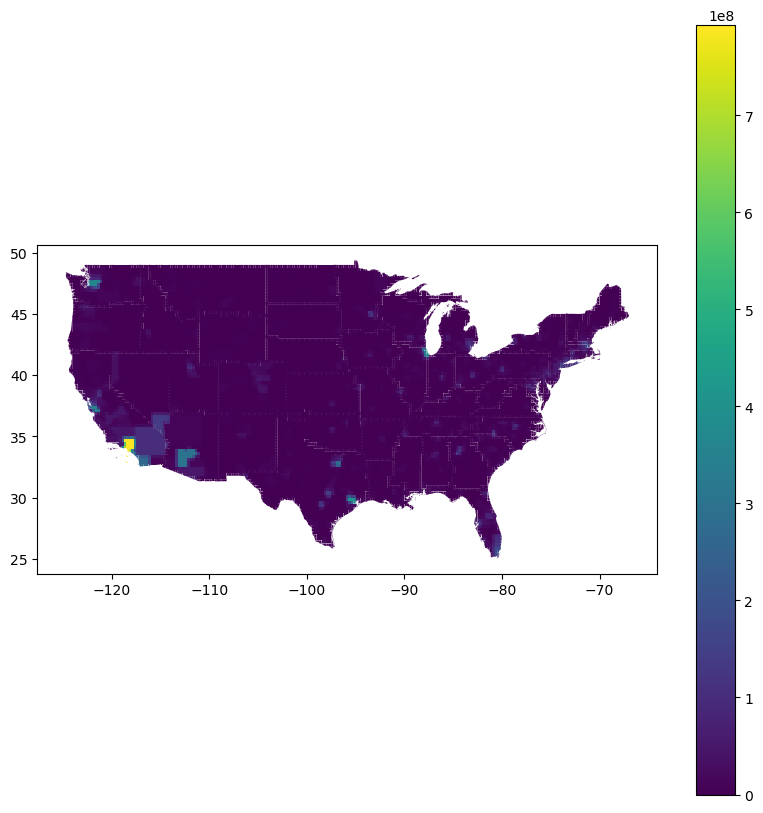

In [170]:
# Plot RGDP on a map
rgdp_geo = full_grid_panel[full_grid_panel["year"] == 2022][["grid_id", "rgdp"]].merge(
    grids[["grid_id", "geometry"]],
    on="grid_id"
)
rgdp_geo = gpd.GeoDataFrame(
    rgdp_geo,
    geometry=rgdp_geo["geometry"],
    crs="EPSG:4326"
)
rgdp_geo.plot(column="rgdp", cmap="viridis", legend=True, figsize=(10, 10), edgecolor=None)

In [181]:
# Check Cook County in 2022
county_controls[(county_controls["FIPS5"] == "17031") & (county_controls["year"] == 2022)]

,FIPS5,year,median_household_income,total_pop,white_pct,black_pct,asian_pct,other_pct,bachelors_pct,rgdp,personal_income,unemployment_rate,RUCC_2013,grid_id,area_weight
296600,17031,2022,1.515583e+03,1.011376e+05,9.559416e-03,4.405488e-03,1.491276e-03,3.898931e-03,5.566153e-03,8.152469e+06,7.288921e+06,9.677555e-02,1.935511e-02,17133,1.935511e-02
296601,17031,2022,8.484377e+03,5.661778e+05,5.351453e-02,2.466235e-02,8.348306e-03,2.182659e-02,3.115986e-02,4.563831e+07,4.080408e+07,5.417589e-01,1.083518e-01,17134,1.083518e-01
296602,17031,2022,1.553176e+03,1.036462e+05,9.796532e-03,4.514763e-03,1.528266e-03,3.995642e-03,5.704219e-03,8.354687e+06,7.469719e+06,9.917601e-02,1.983520e-02,17393,1.983520e-02
296603,17031,2022,4.792246e+04,3.197952e+06,3.022671e-01,1.393008e-01,4.715388e-02,1.232835e-01,1.760008e-01,2.577797e+08,2.304744e+08,3.060026e+00,6.120052e-01,17394,6.120052e-01
296604,17031,2022,5.073109e-10,3.385377e-08,3.199823e-15,1.474649e-15,4.991747e-16,1.305089e-15,1.863158e-15,2.728876e-06,2.439820e-06,3.239367e-14,6.478735e-15,17395,6.478735e-15
296605,17031,2022,7.196947e+04,4.802652e+06,4.539417e-01,2.092005e-01,7.081524e-02,1.851460e-01,2.643163e-01,3.871310e+08,3.461242e+08,4.595517e+00,9.191034e-01,17395,9.191034e-01
296606,17031,2022,2.197379e+02,1.466350e+04,1.385979e-03,6.387329e-04,2.162138e-04,5.652894e-04,8.070129e-04,1.181992e+06,1.056790e+06,1.403108e-02,2.806215e-03,17653,2.806215e-03
296607,17031,2022,3.322687e+03,2.217289e+05,2.095758e-02,9.658371e-03,3.269399e-03,8.547820e-03,1.220296e-02,1.787307e+07,1.597987e+07,2.121659e-01,4.243317e-02,17654,4.243317e-02
296608,17031,2022,5.367926e+04,3.582113e+06,3.385776e-01,1.560346e-01,5.281836e-02,1.380932e-01,1.971433e-01,2.887461e+08,2.581607e+08,3.427619e+00,6.855238e-01,17655,6.855238e-01
296609,17031,2022,7.830400e+04,5.225367e+06,4.938962e-01,2.276137e-01,7.704818e-02,2.014419e-01,2.875806e-01,4.212050e+08,3.765890e+08,5.000000e+00,1.000000e+00,17656,1.000000e+00


<Axes: >

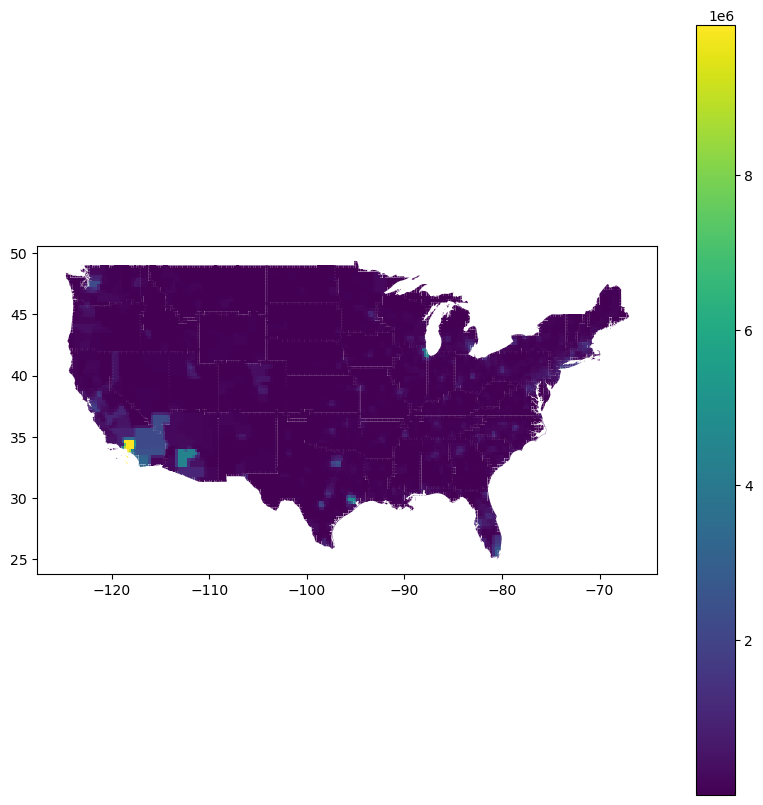

In [172]:
pop_geo = full_grid_panel[full_grid_panel["year"] == 2022][["grid_id", "total_pop"]].merge(
    grids[["grid_id", "geometry"]],
    on="grid_id"
)
pop_geo = gpd.GeoDataFrame(
    pop_geo,
    geometry=pop_geo["geometry"],
    crs="EPSG:4326"
)
pop_geo.plot(column="total_pop", cmap="viridis", legend=True, figsize=(10, 10), edgecolor=None)

<Axes: >

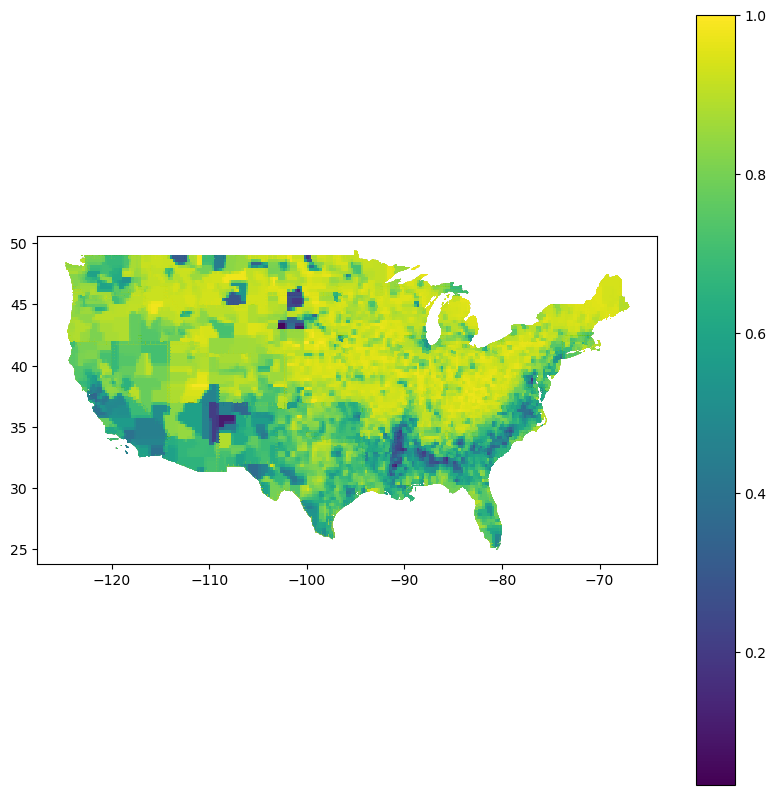

In [173]:
white_pct_geo = full_grid_panel[["grid_id", "white_pct"]].merge(
    grids[["grid_id", "geometry"]],
    on="grid_id"
)
white_pct_geo = gpd.GeoDataFrame(
    white_pct_geo,
    geometry=white_pct_geo["geometry"],
    crs="EPSG:4326"
)
white_pct_geo.plot(column="white_pct", cmap="viridis", legend=True, figsize=(10, 10))

<Axes: >

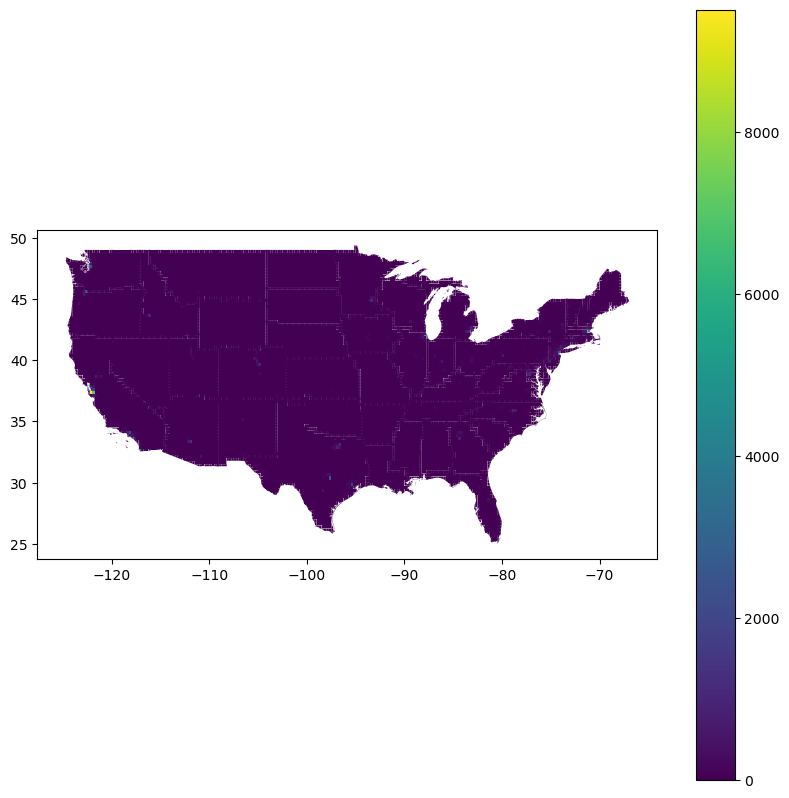

In [178]:
num_patents_geo = full_grid_panel[full_grid_panel["year"] == 2022][["grid_id", "num_patents"]].merge(
    grids[["grid_id", "geometry"]],
    on="grid_id"
)
num_patents_geo = gpd.GeoDataFrame(
    num_patents_geo,
    geometry=num_patents_geo["geometry"],
    crs="EPSG:4326"
)
num_patents_geo.plot(column="num_patents", cmap="viridis", legend=True, figsize=(10, 10), edgecolor=None)